In [1]:
# general imports:
%matplotlib inline
import matplotlib, qiskit, pprint, itertools
from matplotlib import pyplot as plt
import numpy as np
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, IBMQ, transpile, schedule, assemble
from qiskit.circuit import *
from qiskit.circuit.library.standard_gates import *
from qiskit.providers.aer import QasmSimulator
from qiskit.test.mock import FakeAlmaden, FakeMelbourne
from qiskit.visualization import *
from qiskit.circuit.library import *

In [2]:
# import utils for Quantum Information Scrambling Verification Test:
from QSVT_utils import *

In [3]:
# load account:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# get simulators:
f_alma = FakeAlmaden() # simulator f_alma for pulse schedules
f_mel = FakeMelbourne() # simulator f_mel for simulator backend mel
qasm_simulator = Aer.get_backend('qasm_simulator') 

# Experiment 1A: CZ and H Gates
This experiment will test the scrambling properties of the unitary built from CZ gates and H gates. We'd expect a teleportation fidelity of 100% after one application of this scrambler.

First we are going to define the variables for this experiment:

In [4]:
#############################################################################################
########################## SET VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

# number of repetitions of the scrambler:
reps = 1                   # Here we are going to apply it only one time.

# number of qubits within the scrambling unitary:
n = 4                      # The full circuit will have twice this number, for U and U*, 
                           # plus one extra qubit reserved for Bob (not going into the scrambler)

# define list of two qubit gates for scrambling:
two_q_gates = [CZGate()]   # We only use CZ gates this time.

# define list of one qubit gates for scrambling:
one_q_gates = [HGate()]    # We only use H gates this time.

Perfect! Now we are going to prepare ourselfs some handy lists and variables to store qubit indexnumbers based on the number of qubits $n$  we just set. 

In the QSVT_utils module you can find some functions to return yourself all the lists with the qubit indexnumbers, that will be used for one-qubit gates, and nested list containing the indexnumbers of the qubits pairs, the two-qubit gates will be applied to in the scrambling process.

Of course, you can define your own lists instead, for example, if you'd like to use a specific transpiler, mapping, or simply want to mess around a little bit and insert your very personal chaos into your experimental setup 😉

We are going to run our demo experiments on the QasmSimulator, so we will just go ahead and simply run the following cell without any adjustments to get all the lists and variables we need:

In [5]:
#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

Now we got everything we need to get the full experimental circuit by simply running this cell:

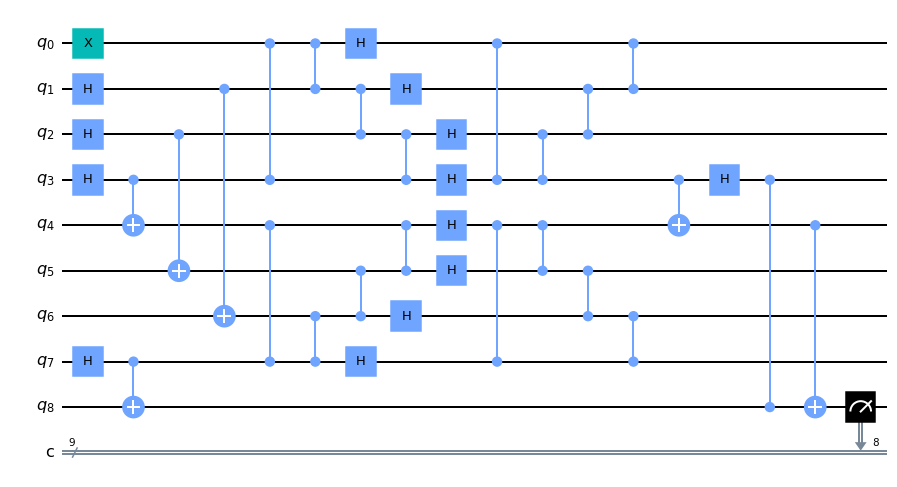

In [6]:
#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1

###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
circ.draw('mpl', plot_barriers=False)

Beatiful! Here it is: our complete circuit we can now transpile and run on a simulator to get the scrambling properties in terms of teleportation fidelity. Remember: 100% fidelity corresponds to our expected full scrambling. Let's prove it!


 Fidelity Bob Qubit:   	 100.0%


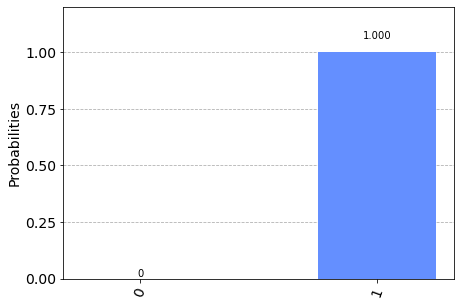

In [7]:
###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

**And that's how you verify perfect scrambling! Nice.**

That was fun indeed. Let's do some more:

# Experiment 1B: CZ and H Gates, reps = 3

Repeating the previous scramber three times now should give us also 100% fidelity.


 Fidelity Bob Qubit:   	 100.0%


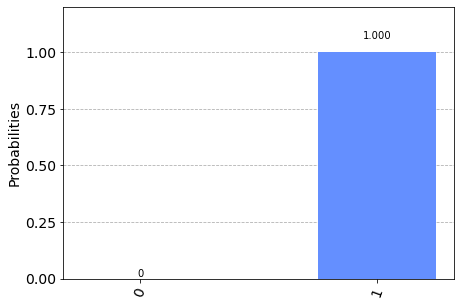

In [8]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 3 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [CZGate()]

# define list of one qubit gates for scrambling
one_q_gates = [HGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit:   \t {}%".format(100*round(bob_1/(bob_1+bob_0),3)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 1C: CZ and H Gates, reps = 2

But what happens if we apply the same scrambler two times? We'd expect the fidelity to go down and settle somewhere close to 50%. Let's see:


 Fidelity Bob Qubit: 	 0.486


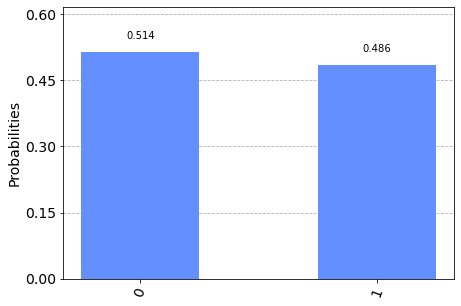

In [9]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 2 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [CZGate()]

# define list of one qubit gates for scrambling
one_q_gates = [HGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

Right on, right on: the fidelity is close enough to 50%.

# Experiment 1D: CZ and H Gates, reps = 4

Okay now, let's do it one more time and see what happens after four repetitions!


 Fidelity Bob Qubit: 	 0.511


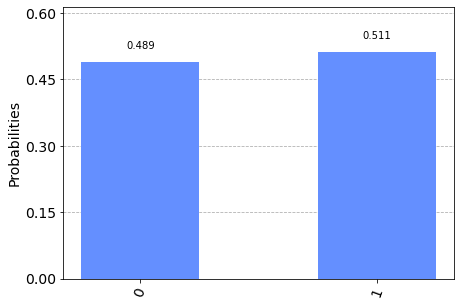

In [10]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 4 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [CZGate()]

# define list of one qubit gates for scrambling
one_q_gates = [HGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

Again we find our fidelity close to 50%. So, this scrambler gives us full scrambling when applied for an odd number of times, and probabilistic scrambling when applied for an even number of times. Is your head also full of ideas for experimental setups right now, making multiple duplicates of our many body sytem and different numbers of scrambler applications? And corresponding black hole representations? Measuring for example the time difference for a teleportation going through one scrambling cycle compared to one going through three cycles... Ok, let's try not to wander off right now and get back to testing some more gate sets for their scrambling properties:

# Experiment 2: CX and TGates


 Fidelity Bob Qubit: 	 0.489


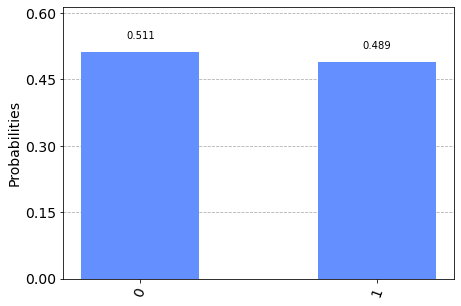

In [11]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [CXGate()]

# define list of one qubit gates for scrambling
one_q_gates = [TGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1

###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 3: SWAP and X Gates


 Fidelity Bob Qubit: 	 1.0


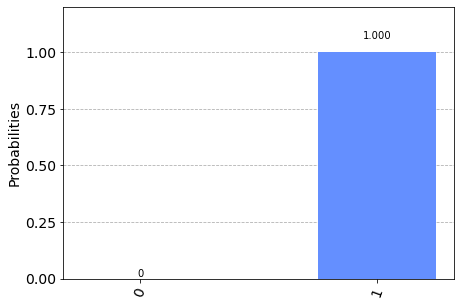

In [12]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [SwapGate()]

# define list of one qubit gates for scrambling
one_q_gates = [XGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1

###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 4: CZGate and SXdgGate


 Fidelity Bob Qubit: 	 0.0


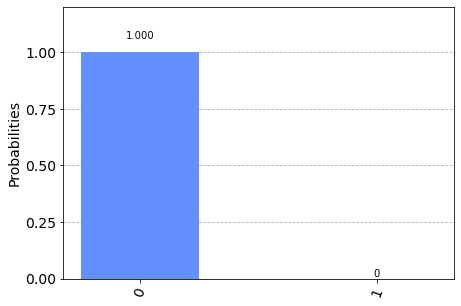

In [13]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [CZGate()]

# define list of one qubit gates for scrambling
one_q_gates = [SXdgGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 5: CHGate and SXdgGate


 Fidelity Bob Qubit: 	 0.425


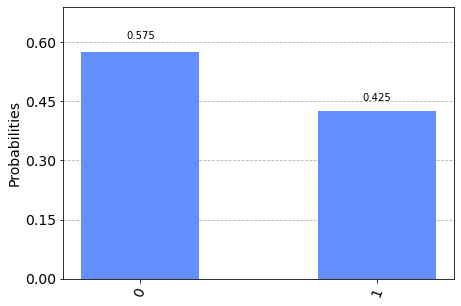

In [14]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [CHGate()]

# define list of one qubit gates for scrambling
one_q_gates = [SXdgGate()]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 6A: 
## RXXGate(theta) and PhaseGate(theta), theta = pi/2, reps = 1


 Fidelity Bob Qubit: 	 1.0


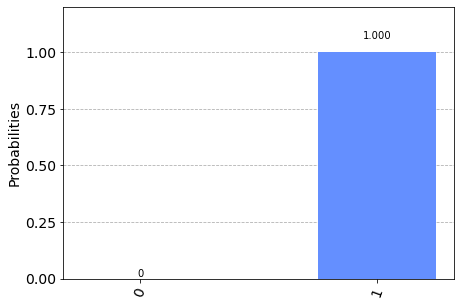

In [15]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

# angle for rotation gate:
theta = pi/2      # when dealing with rotation gates, we can define angles like that,
                  # but there are countless options to deal with gate parameters like this one.
                  # for example picking them randomly, connecting an optimizer..., what you got.

reps = 1 # number of repetitions of the unitary

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [RXXGate(theta)]

# define list of one qubit gates for scrambling
one_q_gates = [PhaseGate(theta)]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 6B: 
## RXXGate(theta) and PhaseGate(theta), theta = pi / 2, reps = 2


 Fidelity Bob Qubit: 	 0.496


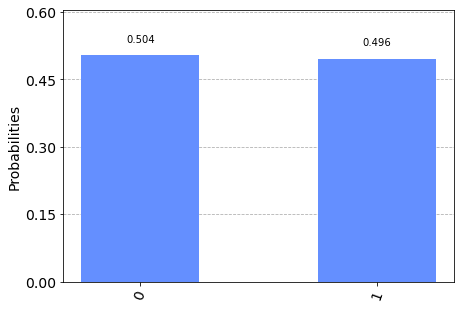

In [16]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 2 # number of repetitions of the unitary

theta = pi/2

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [RXXGate(theta)]

# define list of one qubit gates for scrambling
one_q_gates = [PhaseGate(theta)]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 7A: 
## RXXGate(theta),  RXXGate(-theta), PhaseGate(theta), PhaseGate(-theta), 
## theta = pi/4, reps = 1


 Fidelity Bob Qubit: 	 0.494


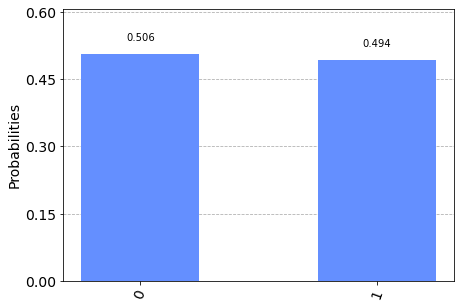

In [17]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 1 # number of repetitions of the unitary

theta = pi/4

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [RXXGate(theta), RXXGate(-theta)]

# define list of one qubit gates for scrambling
one_q_gates = [PhaseGate(theta), PhaseGate(-theta)]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 7B: 
## RXXGate(theta),  RXXGate(-theta), PhaseGate(theta), PhaseGate(-theta), 
## theta = pi/4, reps = 2


 Fidelity Bob Qubit: 	 0.643


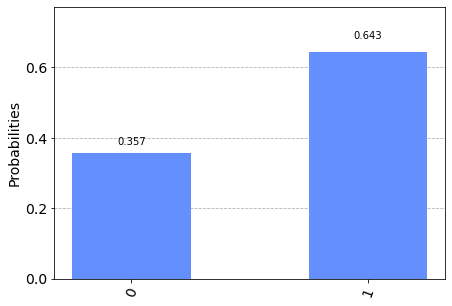

In [18]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 2 # number of repetitions of the unitary

theta = pi/4

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [RXXGate(theta), RXXGate(-theta)]

# define list of one qubit gates for scrambling
one_q_gates = [PhaseGate(theta), PhaseGate(-theta)]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 7C: 
## RXXGate(theta),  RXXGate(-theta), PhaseGate(theta), PhaseGate(-theta), 
## theta = pi/4, reps = 3


 Fidelity Bob Qubit: 	 0.547


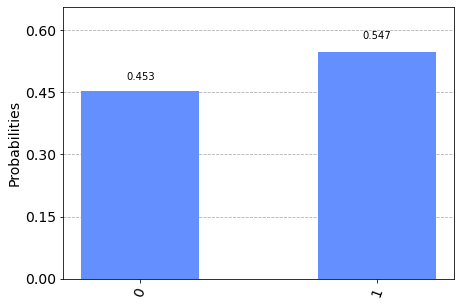

In [19]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 3 # number of repetitions of the unitary

theta = pi/4

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [RXXGate(theta), RXXGate(-theta)]

# define list of one qubit gates for scrambling
one_q_gates = [PhaseGate(theta), PhaseGate(-theta)]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)

# Experiment 7D: 
## RXXGate(theta),  RXXGate(-theta), PhaseGate(theta), PhaseGate(-theta), 
## theta = pi/4, reps = 4


 Fidelity Bob Qubit: 	 0.754


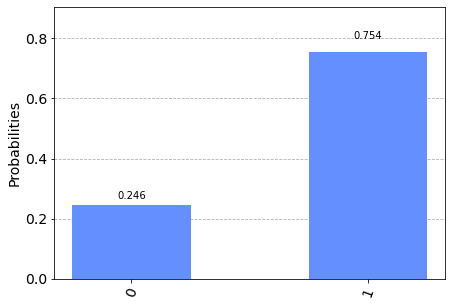

In [40]:
#############################################################################################
########################## DEFINE VARIABLES FOR EXPERIMENTAL SETUP ##########################
#############################################################################################

reps = 4 # number of repetitions of the unitary

theta = pi/4

n = 4 # size of the scrambling unitary / operator

# define list of two qubit gates for scrambling
two_q_gates = [RXXGate(theta), RXXGate(-theta)]

# define list of one qubit gates for scrambling
one_q_gates = [PhaseGate(theta), PhaseGate(-theta)]

#############################################################################################
########################## STRUCTURE CIRC AND PAIRING #######################################
#############################################################################################

# num of qubits in circuit = 1 q for bob + n*2
qnum = 2*n +1

# inums of upper and lower half qubits
fst_half, sec_half = fst_n_sec_half_nums(qnum)

# initial bell pair inums defining the many-body-system
bell_pairs = get_bell_pairs(qnum)

# list of all bell pairs that can be used as basemeas pair
meas_pairs = [x for x in bell_pairs[:-1]]+[[0,qnum-2]] # replace bob and neighbor with alice and bob neighbor

# alice has qubit 0 - bob has qubit with last inum 
inum_alice, inum_bob = 0, qnum-1

# define qubit pair that will be used for base measurement 
# fist pair in the list is the middle pair (furthes away from bob and alice), but any pair will do
basemeas = meas_pairs[0]

#############################################################################################
########################## GET SCRAMBLING TEST TELPO CIRC  ##################################
#############################################################################################

###################################### STEP 1: PREPARATIONS
#############################################################################################

# initialize circ 
circ = QuantumCircuit(qnum,qnum)

# initialize alice qubit in |1> state
circ.x(inum_alice)

# initialize bell pairs
entangle_bell_pairs(circ, bell_pairs)

###################################### STEP 2: SCRAMBLING PROTOCOL
#############################################################################################

# apply scrambling via gateset:
rnum = 0
while rnum < reps:
    apply_gate_set_test(circ, two_q_gates, one_q_gates)
    circ.barrier()
    rnum +=1
    
###################################### STEP 3: BASE MEASUREMENT OF BELL PAIR
#############################################################################################

# disentangle base meas bell pair
disentangle_bell_pair(circ, basemeas)

###################################### STEP 4: BOB DECODING OF BASE MEASUREMENT
#############################################################################################

# apply decoding from measurement
apply_bob_gates(circ,inum_bob,basemeas)

###################################### STEP 5: BOB MEASUREMENT
#############################################################################################

# measure bob qubit
circ.measure(inum_bob,inum_bob)

#############################################################################################
# see circ
#circ.draw('mpl')

###################################### STEP 6: RUN ON SIMULATOR
#############################################################################################

# choose simulator 
be = qasm_simulator

# run on simulator 
shots = 1000
t_qc = transpile(circ, be)
qobj = assemble(t_qc, shots=shots)
result = be.run(qobj).result()

###################################### STEP 7: SEE SIMULATOR RESULTS FOR FIDELITY
#############################################################################################

# see fidelity
bob_1 = sum([v for (k,v) in result.get_counts().items() if k[0]== "1"])
bob_0 = sum([v for (k,v) in result.get_counts().items() if k[0]== "0"])
print("\n Fidelity Bob Qubit: \t {}".format(bob_1/(bob_1+bob_0)))
fid_dict = {"1":bob_1,"0":bob_0} # dict for hist plot
plot_histogram(fid_dict)